In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [ ]:
!kaggle datasets download -d nirmalsankalana/sugarcane-leaf-disease-dataset

 98% 156M/160M [00:05<00:00, 37.5MB/s]
100% 160M/160M [00:05<00:00, 29.3MB/s]


In [ ]:
import zipfile
import os
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image,  ImageTk
from sklearn.model_selection import train_test_split
from pathlib import Path


In [ ]:
import zipfile
import os

zip_file = "/content/sugarcane-leaf-disease-dataset.zip"
extract_folder = "extracted_folder"

# Create a ZipFile object
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # Extract all the contents of zip file in the specified directory
    zip_ref.extractall(extract_folder)

print("Zip file extracted successfully!")

Zip file extracted successfully!


In [ ]:
import os
import glob
import shutil
import random

def get_files(directory):
    if not os.path.exists(directory):
        return 0
    count = 0
    # crawls inside folders
    for current_path, dirs, files in os.walk(directory):
        for dr in dirs:
            count += len(glob.glob(os.path.join(current_path, dr + "/*")))
    return count

def split_dataset(source_dir, train_dir, test_dir, val_dir, split_ratio=(0.6, 0.2, 0.2)):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)

    # Get list of classes
    classes = os.listdir(source_dir)

    for class_name in classes:
        class_source_dir = os.path.join(source_dir, class_name)
        class_train_dir = os.path.join(train_dir, class_name)
        class_test_dir = os.path.join(test_dir, class_name)
        class_val_dir = os.path.join(val_dir, class_name)

        if not os.path.exists(class_train_dir):
            os.makedirs(class_train_dir)
        if not os.path.exists(class_test_dir):
            os.makedirs(class_test_dir)
        if not os.path.exists(class_val_dir):
            os.makedirs(class_val_dir)

        files = os.listdir(class_source_dir)
        random.shuffle(files)

        num_files = len(files)
        num_train = int(num_files * split_ratio[0])
        num_test = int(num_files * split_ratio[1])
        num_val = num_files - num_train - num_test

        train_files = files[:num_train]
        test_files = files[num_train:num_train+num_test]
        val_files = files[num_train+num_test:]

        for file in train_files:
            src = os.path.join(class_source_dir, file)
            dst = os.path.join(class_train_dir, file)
            shutil.copy(src, dst)

        for file in test_files:
            src = os.path.join(class_source_dir, file)
            dst = os.path.join(class_test_dir, file)
            shutil.copy(src, dst)

        for file in val_files:
            src = os.path.join(class_source_dir, file)
            dst = os.path.join(class_val_dir, file)
            shutil.copy(src, dst)

source_dir = "/content/extracted_folder"
train_dir = "/content/train"
test_dir = "/content/test"
val_dir = "/content/val"

split_dataset(source_dir, train_dir, test_dir, val_dir)


In [ ]:
# Train file image count
train_samples = get_files(train_dir)
# Validation file image count
val_samples = get_files(val_dir)
# Test file image count
test_samples = get_files(test_dir)
# To get tags
num_classes = len(glob.glob(os.path.join(train_dir, "*")))

print(num_classes, "Classes")
print(train_samples, "Train images")
print(val_samples, "Validation images")
print(test_samples, "Test images")

5 Classes
1511 Train images
508 Validation images
502 Test images


Found 1511 images belonging to 5 classes.
Found 508 images belonging to 5 classes.
Found 502 images belonging to 5 classes.
74836368/74836368 [==============================] - 4s 0us/step
Epoch 1/50
95/95 [==============================] - 48s 346ms/step - loss: 1.2552 - accuracy: 0.4990 - val_loss: 0.8472 - val_accuracy: 0.6909
Epoch 2/50
95/95 [==============================] - 26s 277ms/step - loss: 0.8318 - accuracy: 0.6724 - val_loss: 0.6046 - val_accuracy: 0.7894
Epoch 3/50
95/95 [==============================] - 27s 282ms/step - loss: 0.6628 - accuracy: 0.7459 - val_loss: 0.5635 - val_accuracy: 0.7874
Epoch 4/50
95/95 [==============================] - 27s 285ms/step - loss: 0.5770 - accuracy: 0.7790 - val_loss: 0.5087 - val_accuracy: 0.8071
Epoch 5/50
95/95 [==============================] - 27s 279ms/step - loss: 0.4811 - accuracy: 0.8306 - val_loss: 0.4325 - val_accuracy: 0.8445
Epoch 6/50
95/95 [==============================] - 27s 284ms/step - loss: 0.4612 - accuracy: 0.

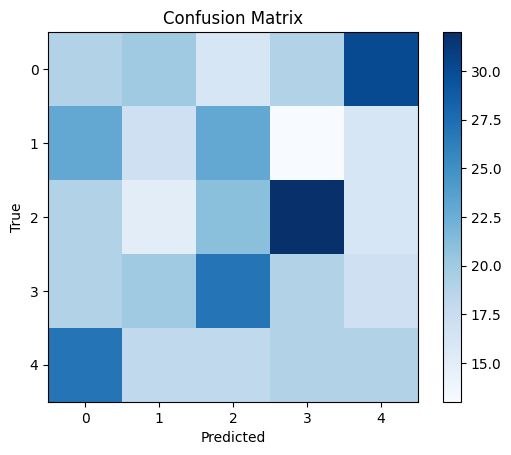

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# Define directories and parameters
train_dir = '/content/train'
validation_dir = '/content/val'
test_dir = '/content/test'
img_height, img_width = 224, 224
batch_size = 16
epochs = 50

# Define data generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load DenseNet201 base model
base_model = DenseNet201(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Plot confusion matrix
predictions = model.predict(test_generator)
predicted_classes = tf.argmax(predictions, axis=1)
true_classes = test_generator.classes

cm = confusion_matrix(true_classes, predicted_classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Define directories and parameters
test_dir = '/content/test'
img_height, img_width = 224, 224
batch_size = 16

# Define data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important: Keep it False to ensure correct labels order
)

# Assuming you already have a trained model object named 'model'

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = tf.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Print classification report
print(classification_report(true_classes, predicted_classes))


Found 502 images belonging to 5 classes.
32/32 [==============================] - 3s 106ms/step - loss: 0.3278 - accuracy: 0.8964
Test accuracy: 0.8964143395423889
32/32 [==============================] - 3s 103ms/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       104
           1       0.89      0.87      0.88        92
           2       0.87      0.88      0.88       103
           3       0.94      0.94      0.94       102
           4       0.87      0.84      0.85       101

    accuracy                           0.90       502
   macro avg       0.90      0.90      0.90       502
weighted avg       0.90      0.90      0.90       502



Found 502 images belonging to 5 classes.
32/32 [==============================] - 3s 104ms/step
Confusion Matrix:
[[98  4  0  0  2]
 [ 7 80  2  2  1]
 [ 0  0 91  3  9]
 [ 0  2  3 96  1]
 [ 2  4  9  1 85]]


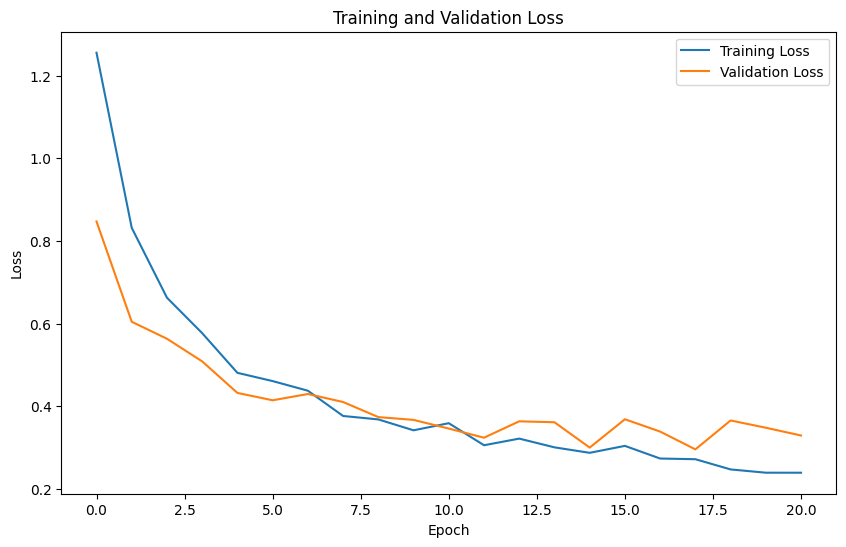

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Define directories and parameters
test_dir = '/content/test'
img_height, img_width = 224, 224
batch_size = 16

# Define data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important: Keep it False to ensure correct labels order
)

# Assuming you already have a trained model object named 'model'
# and its training history named 'history'

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = tf.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Print classification report
class_labels = list(test_generator.class_indices.keys())
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)



# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


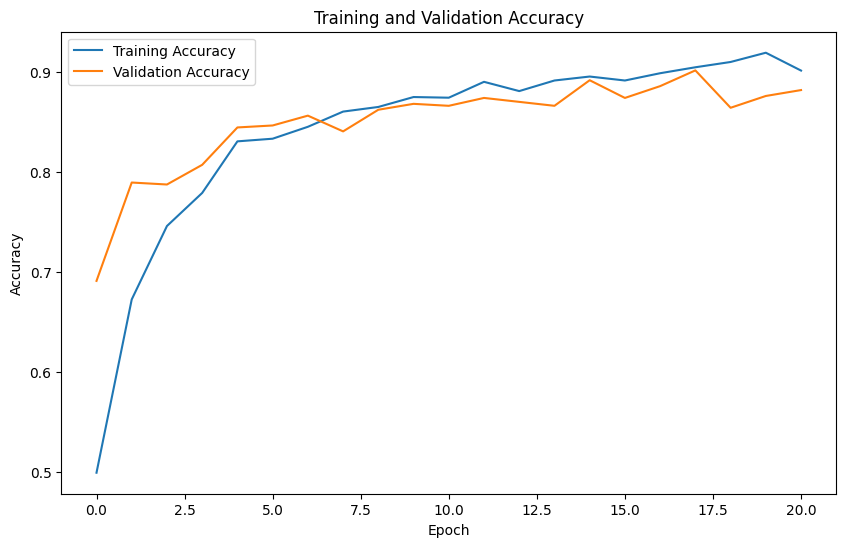

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
